# Capstone Project - Movie Recommendations for New Users
*Catherine Hocknell* | 10 April, 2023

##### Notebook 4/5

This notebook will cover the Content Based Recommender System, looking into the information regarding the movies themselves and generating recommendations based on their contents.

Please note that this notebook includes errors that were found during the de-bugging stages of creating the recommender system function. These have all been resolved for the final result.

---
# Content Based Recommender System

In [85]:
# import all necessary packages

import numpy as np
import pandas as pd

#graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#stats
from scipy import stats
from scipy.stats import norm

# nlp
import string
import nltk
import contractions
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

#warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0 Data Import

The data required for this notebook is contained within the following .csv file:

|Filename|Description|
|-|-|
|rotten_tomatoes_movies.csv|Full movies dataset from Kaggle|

The file is imported and assigned to a dataframe below.

In [4]:
# import movies database
movies_df = pd.read_csv('data/rotten_tomatoes_movies.csv')

# 1 EDA
As with any data analysis problem, a brief EDA is carried out to ensure there will not be any issues encountered during the creation of the recommender system. This is one below, where the movies database `movies_df` is reviewed in terms of its contents, size and numeric values.

In [5]:
# overview of the contents of the df
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [6]:
# example of the first row of the database
movies_df.head(1)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76


In [7]:
# numeric value statistics
movies_df.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


The movies dataset contains a wide range of information relating to each movie id, however also contains a large number of missing values. In this case, not all of the available columns will be used, so only the ones we are concerned with in terms of the Content Based Recommender System will be evaluated in full within this notebook.

## 1.1 Cleaning Keyword Input Columns

A content based recommender system is based on keywords associated to the movies that are available. It is therefore essential that the relevant information is available for each of the movies that will be included within the recommender system. This means dropping/populating any missing values. The columns that will be used to populate the content based recommender system are:
- info
- rating
- genres
- directors
- actors

First, a new dataframe that will be used to populate the keywords for each movie is generated below. 

In [8]:
# create an empty df to be used to create keywords
keyword_df = pd.DataFrame()

In [9]:
# include movie title 
keyword_df['title'] = movies_df['movie_title']

In [10]:
keyword_df.head()

,title
0,Percy Jackson & the Olympians: The Lightning T...
1,Please Give
2,10
3,12 Angry Men (Twelve Angry Men)
4,"20,000 Leagues Under The Sea"


### 1.1.1 movie_info
This is the general plot of the movie. Investigating the missing values below:

In [11]:
# calculate number of missing values
info_null = movies_df['movie_info'].isna().sum()
print(f'There are {info_null} movies not containing a description, covering {100*info_null/movies_df.shape[0]:.2f}% of all movies.')

There are 321 movies not containing a description, covering 1.81% of all movies.


This evaluates to a very small amount of the overall data, so can be filled with an empty string `''`.

In [12]:
# copy into keyword_df
keyword_df['info'] = movies_df['movie_info']
keyword_df['info'].fillna('', inplace = True)

In [13]:
# sanity check
keyword_df['info'].isna().sum()

0

Now that there are no null values, the `movie_info` column can be fully tokenised in order to prepare it for the vectorisation which will be required in order to evaluate the similarities between the movies. This corresponds to the following steps:
1. Remove contractions
2. Tokenise
3. Convert to lowercase
4. Remove punctuation
5. Remove stopwords
6. Stem the words for commonality

Each of these steps have been carried out below, with a sanity check carried out after each one in order to view that the process has taken place.

In [14]:
# remove contractions
keyword_df['info'] = keyword_df['info'].apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
keyword_df.head(1)

,title,info
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per..."


In [15]:
# tokenise
keyword_df['info'] = keyword_df['info'].apply(word_tokenize)
keyword_df.head(1)

,title,info
0,Percy Jackson & the Olympians: The Lightning T...,"[Always, trouble-prone, ,, the, life, of, teen..."


In [16]:
#convert to lowercase
keyword_df['info'] = keyword_df['info'].apply(lambda x: [word.lower() for word in x])
keyword_df.head(1)

,title,info
0,Percy Jackson & the Olympians: The Lightning T...,"[always, trouble-prone, ,, the, life, of, teen..."


In [17]:
# define punctuation list
punc = string.punctuation

#removes list items not in punctuation list
keyword_df['info'] = keyword_df['info'].apply(lambda x: [word for word in x if word not in punc])
keyword_df.head(1)

,title,info
0,Percy Jackson & the Olympians: The Lightning T...,"[always, trouble-prone, the, life, of, teenage..."


In [18]:
# remove stopwords
stop_words = set(stopwords.words('english'))
keyword_df['info'] = keyword_df['info'].apply(lambda x: [word for word in x if word not in stop_words])
keyword_df.head(1)

,title,info
0,Percy Jackson & the Olympians: The Lightning T...,"[always, trouble-prone, life, teenager, percy,..."


In [19]:
#apply stemmer
stemmer = nltk.stem.PorterStemmer()
keyword_df['info'] = keyword_df['info'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
keyword_df.head(1)

,title,info
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...


The `info` column within the newly defined `keyword_df` is now in an appropriate format for carrying out the selected vectorising technique, which will happen once the keywords have been completed.

### 1.1.2 content_rating

Moving on to the `content_rating` column, the first step, as with the `movie_info` is to check to see if there are any null values. This is done below.

In [20]:
# count of the null values
conrat_null = movies_df['content_rating'].isna().sum()
print(f'There are {conrat_null} movies not containing a content rating.')

There are 0 movies not containing a content rating.


The above shows that there are no missing values, however the initial review of the `movies_df` indicated that there might be another rating value that would not be useful in terms of calculating similarity. Each of the possible rating options, and how many movies have them, are shown below.

In [21]:
# count of each of the rating options
movies_df['content_rating'].value_counts()

R        6377
NR       5474
PG-13    2979
PG       2168
G         676
NC17       38
Name: content_rating, dtype: int64

The second highest occurring rating is NR, meaning 'Not Rated', which can cover a wide variety of different types of movie. This will therefore not be a good measure of similarity for a movie, so the decision is made to replace these with an empty string `''`. This is carried out below.

In [22]:
# copy into keyword_df while replacing NR with ''
keyword_df['content_rating'] = movies_df['content_rating'].apply(lambda x: '' if x == 'NR' else x)

With the replace carried out, a sanity check is carried out to ensure there is no longer any text for non-rated movies.

In [23]:
# sanity check
keyword_df['content_rating'].value_counts()

R        6377
         5474
PG-13    2979
PG       2168
G         676
NC17       38
Name: content_rating, dtype: int64

In [24]:
# sanity check
keyword_df.head()

,title,info,content_rating
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG
1,Please Give,kate catherin keener husband alex oliv platt w...,R
2,10,success middle-ag hollywood songwrit fall hope...,R
3,12 Angry Men (Twelve Angry Men),follow close argument murder trial 12 member j...,
4,"20,000 Leagues Under The Sea",1866 professor pierr m. aronnax paul luka assi...,G


The `content_rating` column has now been successfully added to the `keywords_df` dataframe.

### 1.1.3 genres
Following a similar method, a count of the movies with no genre inputs has been carried out below.

In [25]:
gen_null = movies_df['genres'].isna().sum()
print(f'There are {gen_null} movies not containing a genre, covering {100*gen_null/movies_df.shape[0]:.2f}% of all movies.')

There are 19 movies not containing a genre, covering 0.11% of all movies.


As with the movie info, this is a very small amount in relation to the entire movie dataset. These will therefore also be filled with an empty string `''`.

In [26]:
# copy in genre information to keywords_df
keyword_df['genres'] = movies_df['genres']

In [27]:
# fill null values
keyword_df['genres'].fillna('', inplace = True)

Also need to make sure that the genre names are kept whole, so look into removing the spaces between the words and remove any punctuation. First, convert to a list.

In [28]:
# convert to list
keyword_df['genres'] = keyword_df['genres'].str.split(', ')
#sanity check
keyword_df.head(1)

,title,info,content_rating,genres
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,"[Action & Adventure, Comedy, Drama, Science Fi..."


In [29]:
#remove spaces
keyword_df['genres'] = keyword_df['genres'].apply(lambda x: ' '.join([i.replace(' ','') for i in x]))
keyword_df.head(1)

,title,info,content_rating,genres
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,Action&Adventure Comedy Drama ScienceFiction&F...


The `genres` column has now been successfully tokenised and added to the `keywords_df` dataframe.

### 1.1.4 directors

In [79]:
dir_null = movies_df['directors'].isna().sum()
print(f'There are {dir_null} movies not containing directors, covering {100*dir_null/movies_df.shape[0]:.2f}% of all movies.')

There are 194 movies not containing directors, covering 1.10% of all movies.


As with the previous examples, this is a very small amount in relation to the entire movie dataset. These will therefore also be filled with an empty string `''`.

In [31]:
# copy in genre information
keyword_df['directors'] = movies_df['directors']
#fill na values
keyword_df['directors'].fillna('', inplace = True)

As with genres, in order to be included as one token within the future vectorisation, there is the need to make sure that the director names are kept as one continuous string with no spaces. This is carried out below.

In [32]:
# convert to list
keyword_df['directors'] = keyword_df['directors'].str.split(', ')
keyword_df.head(1)

,title,info,content_rating,genres,directors
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,Action&Adventure Comedy Drama ScienceFiction&F...,[Chris Columbus]


In [33]:
#remove spaces
keyword_df['directors'] = keyword_df['directors'].apply(lambda x: ' '.join([i.replace(' ','') for i in x]))
keyword_df.head(1)

,title,info,content_rating,genres,directors
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,Action&Adventure Comedy Drama ScienceFiction&F...,ChrisColumbus


The `directors` column has now been successfully tokenised and added to the `keywords_df` dataframe.

### 1.1.5 actors

In [78]:
act_null = movies_df['actors'].isna().sum()
print(f'There are {act_null} movies not containing actors, covering {100*act_null/movies_df.shape[0]:.2f}% of all movies.')

There are 352 movies not containing actors, covering 1.99% of all movies.


As with the previous examples, this is a very small amount in relation to the entire movie dataset. These will therefore also be filled with an empty string `''`.

In [35]:
# copy in genre information
keyword_df['actors'] = movies_df['actors']
#fill na values
keyword_df['actors'].fillna('', inplace = True)

As with directors, there is the need to ensure that the actor names are kept as one continuous string with no spaces in order for a more accurate vectorisation later on.

In [36]:
# convert to list
keyword_df['actors'] = keyword_df['actors'].str.split(', ')
keyword_df.head(1)

,title,info,content_rating,genres,directors,actors
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,Action&Adventure Comedy Drama ScienceFiction&F...,ChrisColumbus,"[Logan Lerman, Brandon T. Jackson, Alexandra D..."


In [37]:
#remove spaces
keyword_df['actors'] = keyword_df['actors'].apply(lambda x: ' '.join([i.replace(' ','') for i in x]))
keyword_df.head(1)

,title,info,content_rating,genres,directors,actors
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,Action&Adventure Comedy Drama ScienceFiction&F...,ChrisColumbus,LoganLerman BrandonT.Jackson AlexandraDaddario...


The `actors` column has now been successfully tokenised and added to the `keywords_df` dataframe.

---
*Optional extra for future investigation:*

Create a new column with only top 5 actors to see how this impacts the vectorisation scoring.

In [38]:
# create new list column for top actors
keyword_df['top_actors'] = keyword_df['actors'].str.split(' ')

In [39]:
# remove spaces, limiting the number to only the top 5
keyword_df['top_actors'] = keyword_df['top_actors'].apply(lambda x: ' '.join(x[:6]))
keyword_df.head(1)

,title,info,content_rating,genres,directors,actors,top_actors
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,Action&Adventure Comedy Drama ScienceFiction&F...,ChrisColumbus,LoganLerman BrandonT.Jackson AlexandraDaddario...,LoganLerman BrandonT.Jackson AlexandraDaddario...


In [40]:
# sanity check
keyword_df.loc[0,'top_actors']

'LoganLerman BrandonT.Jackson AlexandraDaddario JakeAbel SeanBean PierceBrosnan'

---

## 1.2 Generate Keywords

`info`, `content_rating`, `genres`, `directors` and `actors` can now be combined into one `keywords` column in order to carry out vectorisation.

*Note: two keyword columns have been generated here, one with all the actors (`keywords`) and one with only the top five actors (`keywords2`).*

In [41]:
# combine columns to create keywords for vectorisation
keyword_df['keywords'] = keyword_df['info'] + ' ' + keyword_df['content_rating'] + ' ' +\
                        keyword_df['genres'] + ' ' + keyword_df['directors'] + ' ' + keyword_df['actors']

In [42]:
# combine columns to create keywords2 for vectorisation
keyword_df['keywords2'] = keyword_df['info'] + ' ' + keyword_df['content_rating'] + ' ' +\
                        keyword_df['genres'] + ' ' + keyword_df['directors'] + ' ' + keyword_df['top_actors']

In [43]:
# sanity check
keyword_df.head(1)

,title,info,content_rating,genres,directors,actors,top_actors,keywords,keywords2
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...,PG,Action&Adventure Comedy Drama ScienceFiction&F...,ChrisColumbus,LoganLerman BrandonT.Jackson AlexandraDaddario...,LoganLerman BrandonT.Jackson AlexandraDaddario...,alway trouble-pron life teenag perci jackson l...,alway trouble-pron life teenag perci jackson l...


A new dataframe is then created with only the film title and the `keywords` column, which is what will be used for the vectorisation stage.

In [44]:
# create new df
final_df = keyword_df[['title', 'keywords']]
# sanity check
final_df.head()

,title,keywords
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...
1,Please Give,kate catherin keener husband alex oliv platt w...
2,10,success middle-ag hollywood songwrit fall hope...
3,12 Angry Men (Twelve Angry Men),follow close argument murder trial 12 member j...
4,"20,000 Leagues Under The Sea",1866 professor pierr m. aronnax paul luka assi...


As above, a new dataframe is also created with the `keywords2` column containing only the top five actors.

In [45]:
# new df with top actors
final_df2 = keyword_df[['title', 'keywords2']]
# sanity check
final_df2.head()

,title,keywords2
0,Percy Jackson & the Olympians: The Lightning T...,alway trouble-pron life teenag perci jackson l...
1,Please Give,kate catherin keener husband alex oliv platt w...
2,10,success middle-ag hollywood songwrit fall hope...
3,12 Angry Men (Twelve Angry Men),follow close argument murder trial 12 member j...
4,"20,000 Leagues Under The Sea",1866 professor pierr m. aronnax paul luka assi...


At this point it is interesting to review the length of the `keywords` column to observe the distribution throughout the movies within the dataset. First a `keywords_length` column is created, which is then plotted below.

In [81]:
final_df['keywords_length'] = final_df['keywords'].apply(lambda x: len(x))

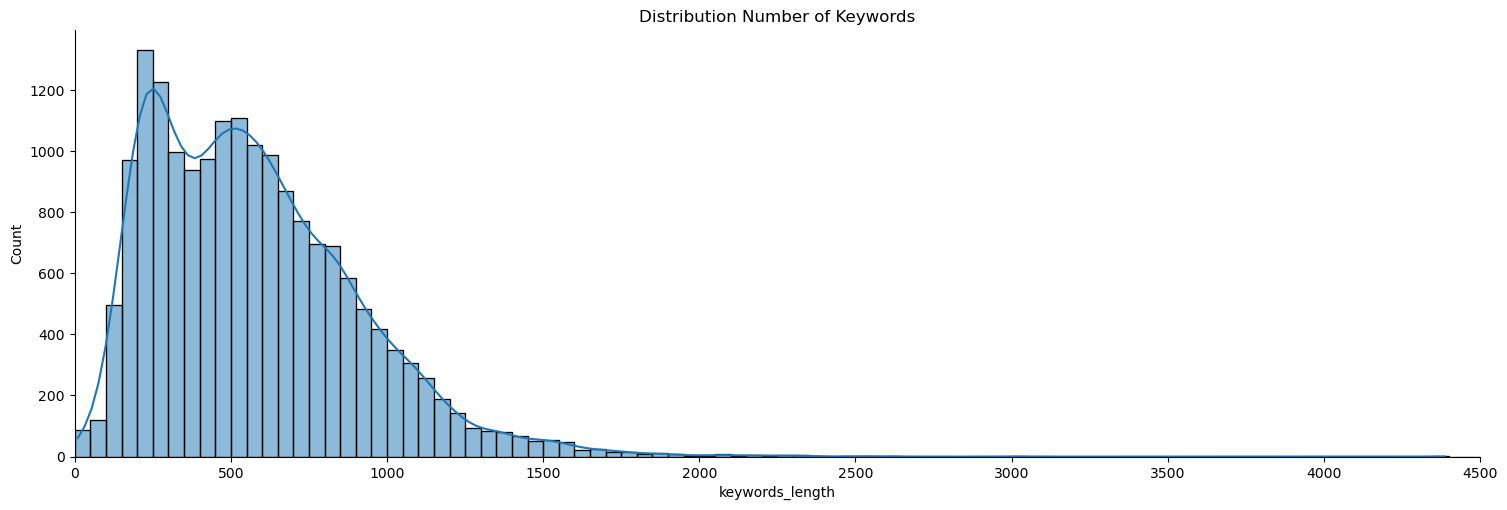

In [48]:
# plot keywords
sns.displot(data=final_df.dropna(), bins=list(range(0, 5000, 50)), height=5, x='keywords_length', aspect=3, kde=True)
plt.title('Distribution Number of Keywords')
plt.xlim([0, 4500])
plt.show()

# 2 Keyword Vectorisation
Within a content based recommender systems, recommendations are made based on the similarity between the the movie keywords that have been generated. In order to calculate this similarity, the keywords themselves must be vectorised to give them a numerical value. This is done using a **TF-IDF** vectoriser, which allocates a score to each token within the `keywords` column based on the number of occurances within the document in question, and the corpus of documents as a whole. In this case, a number of different vectorisations have been carried out in order to see how they will impact the overall recommender system. These are detailed below.

## 2.1 Baseline Keywords (max_features)
First, the vectorisation is carried out on the `keywords` column while assigning the `max_features` hyperparameter as 5000. This defines the maximum number of tokens to be assigned as 5000 throughout the entire list of movies. The vectorisation is carried out below.

In [49]:
# method 1: max 5000 tokens
# 1. Instantiate
tfidf = TfidfVectorizer(max_features = 5000)

# 2. fit
tfidf.fit(final_df['keywords'])

# 3. transform
tf_vectorised = tfidf.transform(final_df['keywords'])

# sanity check
tf_vectorised.shape

(17712, 5000)

With the vectorisation now having taken place, this is then made into a dataframe below, assigning the index to align with the original `final_df` dataframe to align with the movie titles.

In [50]:
# generate df
count_matrix = pd.DataFrame(tf_vectorised.toarray(), index=final_df['keywords'].index.tolist())

At this point it is interesting to look into a sample of the tokens that have been selected. A selection from within the vectorised data is shown below.

In [51]:
print(tfidf.get_feature_names_out()[1940:1950])

['hale' 'haley' 'half' 'halholbrook' 'hall' 'halleberry' 'halloran'
 'halloween' 'hamilton' 'han']


With this first vectorisation completed, the same methodology is carried out for two other variations of TF-IDF.

## 2.2 Baseline Keywords (min_df)
The second vectorisation is carried out using a different hyperparameter within the TF-IDF vectoriser - this time looking at the `min_df`, which assigns the minimum number of documents (keywords) which a token must occur in before being taken into account. In this case the `min_df` is set to 30, meaning a token must be mentioned in at least 30 different keyword entries before being used within the vectoriser. The `keywords` column is vectorised and converted to a dataframe below.

In [52]:
# method 2: minimum occurence in 30 documents
# 1. Instantiate
tfidf2 = TfidfVectorizer(min_df = 30)

# 2. fit
tfidf2.fit(final_df['keywords'])

# 3. transform
tf_vectorised2 = tfidf2.transform(final_df['keywords'])

# sanity check
tf_vectorised2.shape

(17712, 4113)

In [54]:
# create df
count_matrix2 = pd.DataFrame(tf_vectorised2.toarray(), index=final_df['keywords'].index.tolist())

## 2.3 Top Actors Keywords (max_features)
The final vectorisation is carried out using the same method as the first, however this time using the top actors keywords column, `keywords2`. As with the first, this vectorisation is completed for a maximum of 5000 features, which is then converted to a third vectorised dataframe below.

In [55]:
# method 3: max 5000 tokens with top 5 actors
# 1. Instantiate
tfidf3 = TfidfVectorizer(max_features = 5000)

# 2. fit
tfidf3.fit(final_df2['keywords2'])

# 3. transform
tf_vectorised3 = tfidf3.transform(final_df2['keywords2'])

# sanity check
tf_vectorised3.shape

(17712, 5000)

In [56]:
count_matrix3 = pd.DataFrame(tf_vectorised3.toarray(), index=final_df2['keywords2'].index.tolist())

## 2.4 Dimensionality Reduction
It is also possible to carry out dimensionality reduction on the dataframes that have been created above. One example of this is carried out below, where the first dataframe `count_matrix` is reduced from 5000 components to 3000 components, using the built-in model *TruncatedSVD*.

In [82]:
# reduce dimensionality for potential improved performance
svd = TruncatedSVD(n_components=3000)
reduced_data = svd.fit_transform(count_matrix)

# sanity check
reduced_data.shape

(17712, 3000)

# 3 Similarity Calculation
As mentioned previously, the recommender system is built on the similarity between the movies. This is calculated using a method called **cosine similarity**, which is a distance measure that looks at the similarity in direction of vectors. In this case, four similarity matrices have been created, one for each of the dataframes created above. These are detailed in the table below.

|Name|Description|
|-|-|
|`similarities`|5000 components reduced to 3000 components|
|`similarities2`|All keywords with 5000 components|
|`similarities3`|All keywords, `min_df` set to 30 (4113 components)|
|`similarities4`|Keywords with only top 4 actors with 5000 components|

The similarity matrices are created below, which will consist of a table where both the rows and columns are equivalent to the index of the movie, and the contents will be the measure of similarity between the keywords of each movie.

In [83]:
# dimension reduction --> 3000 components
similarities = cosine_similarity(reduced_data, dense_output=False)

# sanity check
similarities.shape

(17712, 17712)

Before generating the remaining matrices, this first similarty matrix will be tested. This is done by definiting a specific movie, locating the index within the movie dataset, then creating and sorting a dataframe from the similarity matrix row of this same index as shown below.

In [ ]:
# assign a movie to search for
title = 'Harry Potter and the Chamber of Secrets'

# Get the index definition for the desired movie
movie_index = movies_df[movies_df['movie_title'] == title].index

# Create a dataframe with the movie titles using the above defined movie index similarities
sim_df = pd.DataFrame({'Movie Title':movies_df['movie_title'], 
                       'Similarity': np.array(similarities[movie_index, :]).squeeze()})

# Sort in descending order to return the top 10 most similar movies
sim_df.sort_values(by='Similarity', ascending=False).head(10)

The above table shows the most similar movie is the one defined as the input, with the remaining nine looking to be accurate options for similar movies.

Now that the building of the initial similarity matrix has been confirmed, the remaining three are created below. These will be factored in to the recommender system within the next section of this notebook.

In [58]:
# no dimension reduction --> 5000 components
similarities2 = cosine_similarity(count_matrix, dense_output=False)

In [59]:
# min_df = 30 --> 4113 components
similarities3 = cosine_similarity(count_matrix2, dense_output=False)

In [60]:
# only top 4 actors --> 5000 components
similarities4 = cosine_similarity(count_matrix3, dense_output=False)

# 4 Recommender System Generation
A recommender system is generated using a similar method as was used to test the similarity matrix above, where a function will be generated that takes a movie title as an input, then will output the top ten most similar movies based on the similarity matrix that is to be used. The evaluation of the recommender system is outlined in this section.

## 4.1 First Iteration
The first system will be created in the same method as the previous test, taking in an exact movie title and outputting the table of similar movies. In this case, the inputs to the system are:

|Input|Definition|
|-|-|
|`title`|Exact Movie Title|
|`movies`|Movie reference dataframe|
|`similarities`|Similarity matrix|
|`vote_threshold`|Minimum number of ratings for the movie to be considered|

In [84]:
def content_recommender1(title, movies = movies_df, similarities = similarities, vote_threshold=20) :
    # define default values for movies_df, similarities and vote_threshold
    
    # Get the movie index by the defined title
    movie_index = movies[movies['movie_title'] == title].index
    
    # Create a dataframe with the information related to the defined movie, mostly taken from the movies dataframe
    sim_df = pd.DataFrame(
        {'Movie Title': movies['movie_title'], # title of the movie
         'Description': movies['movie_info'], # description of the movie
         'Similarity': np.array(similarities[movie_index, :]).squeeze(), # similarity score from defined matrix
         'Count': movies['tomatometer_count'], # number of reviews
         'Rating': movies['tomatometer_status'] # Rating of the movie
        })
    
    # Get the top 10 movies with votes over the defined threshold
    top_movies = sim_df[sim_df['Count'] > vote_threshold].sort_values(by='Similarity', ascending=False).head(10)
    
    # output table of top 10 movies
    return top_movies

With the function defined, an initial test is carried out below.

In [110]:
# Test the recommender
content_recommender1("Wild")

,Movie Title,Description,Similarity,Count,Rating
17356,Wild,Driven to the edge by the loss of her beloved ...,1.000000,272.0,Certified-Fresh
8242,The Importance of Being Earnest,Two young gents have taken to bending the trut...,0.184755,116.0,Rotten
10708,Mud,"While exploring a Mississippi River island, Ar...",0.169839,181.0,Certified-Fresh
17068,Water for Elephants,"Jacob Jankowski (Robert Pattinson), a veterina...",0.164073,197.0,Fresh
9364,Legally Blonde,Elle Woods (Reese Witherspoon) has it all. She...,0.163802,147.0,Fresh
2563,Allure,Although Laura works as a house cleaner for he...,0.160572,30.0,Rotten
3444,Best Laid Plans,Returning to his dreary hometown as a wealthy ...,0.159964,21.0,Rotten
12405,Relic,A woman links her mother's increasingly volati...,0.152562,193.0,Certified-Fresh
17001,Walk the Line,The rise of country music legend Johnny Cash (...,0.151387,210.0,Certified-Fresh
11904,Pleasantville,Impressed by high school student David's (Tobe...,0.137543,96.0,Certified-Fresh


Further movie titles are input into the system in order to carry out further testing of the system. Below is an error caused by one of the test cases.

In [112]:
# Test the recommender
content_recommender1("The Jungle Book")

ValueError: Per-column arrays must each be 1-dimensional

The movie index value for this movie is investigated below.

In [115]:
# review index value
movies_df[movies_df['movie_title'] == 'The Jungle Book'].index

Int64Index([849, 15265], dtype='int64')

This implies that there are two movies within the dataset that have exactly the same name 'The Jungle Book'. The recommender system is then updated to account for this.

## 4.2 Second Iteration
The second iteration of the recommender system will allow for a movie title input that can appear more than once within the assigned movie dataset, and will take into account the one with the highest average rating. This takes the same inputs as the first iteration.

In [117]:
def content_recommender2(title, movies = movies_df, similarities = similarities, vote_threshold=20) :
    
    # Get the movie by the contents of the title
    movie_options = movies[movies['movie_title'] == title].index
    
    # there can sometimes be movies with the exact same title which needs to be considered to avoid errors
    if len(movie_options) == 1:
        # if there is only one movie of that name (i.e. one index value) take this as the index
        movie_index = movie_options[0]
    else:
        # if more than one movie, pick the one with the highest rating to be used as the input
        option_index = movies.iloc[movie_options,:][['tomatometer_rating']].values.argmax()
        movie_index = movie_options[option_index]
    
    # define the full title of the movie that is being compared
    print(f'Movies similar to {movies.iloc[movie_index,1]}:')
    
    # Create a dataframe with the movie titles
    sim_df = pd.DataFrame(
        {'Movie Title': movies['movie_title'],
         'Description': movies['movie_info'],
         'Similarity': np.array(similarities[movie_index, :]).squeeze(),
         'Count': movies['tomatometer_count'],
         'Rating': movies['tomatometer_status']
        })
    
    # Get the top 10 movies with votes over the defined threshold
    top_movies = sim_df[sim_df['Count'] > vote_threshold].sort_values(by='Similarity', ascending=False).head(10)
    
    # output table of top ten movies
    return top_movies

The same movie input is used in the updated recommender system to review whether the initial issue has been resolved.

In [120]:
# Test the recommender
content_recommender2("The Jungle Book")

Movies similar to The Jungle Book:


,Movie Title,Description,Similarity,Count,Rating
15265,The Jungle Book,"Raised by a family of wolves since birth, Mowg...",1.000000,323.0,Certified-Fresh
10649,Mowgli: Legend of the Jungle,Human child Mowgli is raised by a wolf pack in...,0.255180,104.0,Rotten
8820,The Jungle Book 2,Wild child Mowgli (Haley Joel Osment) has grow...,0.230400,92.0,Rotten
849,The Jungle Book,In this classic Walt Disney animation based on...,0.209611,40.0,Certified-Fresh
10577,Moonlight,A look at three defining chapters in the life ...,0.173324,384.0,Certified-Fresh
17493,Wonder Park,Buckle up for an epic adventure where anything...,0.168925,106.0,Rotten
17703,Zookeeper,Kindhearted Griffin Keyes (Kevin James) is one...,0.168498,132.0,Rotten
9521,"Like Father, Like Son",Ryota learns that his biological son was switc...,0.167751,101.0,Certified-Fresh
14902,The Escape,Tara is a housewife in suburban London who's r...,0.165673,46.0,Certified-Fresh
1019,Rudyard Kipling's The Jungle Book,"When his father is killed by a jungle tiger, M...",0.165611,41.0,Certified-Fresh


This shows that the original issue has been fixed and, as expected, there are two movies within the table called 'The Jungle Book'. The description column within the output table allows for the difference in these movies to be reviewed, but another way to do this would be to include the release date. This will be incorporated into the next recommender, which will be built following further testing of other use-cases. 

In [121]:
# Test the recommender
content_recommender2("Harry Potter")

ValueError: attempt to get argmax of an empty sequence

The above error has occurred due to the fact that the movie input is currently defined as the exact movie title within the defined dataframe. This will be resolved in the next iteration.

## 4.3 Iteraton 3
The third iteration of the recommender system will be updated to allow for any movie containig the text provided in the input to be considered, still looking for the one with the highest average rating. The output table will also be updated to include the release date. The input values are now defined as the following:

|Input|Definition|
|-|-|
|`title`|Excerpt from Movie Title|
|`movies`|Movie reference dataframe|
|`similarities`|Similarity matrix|
|`vote_threshold`|Minimum number of ratings for the movie to be considered|

In [122]:
def content_recommender3(title, movies = movies_df, similarities = similarities, vote_threshold=20) :
    
    # Get the movie by the contents of the title
    movie_options = movies[movies['movie_title'].str.contains(title)].index
    
    # there can sometimes be movies with the exact same title which needs to be considered to avoid errors
    if len(movie_options) == 1:
        # if there is only one movie of that name (i.e. one index value) take this as the index
        movie_index = movie_options[0]
    else:
        # if more than one movie, pick the one with the highest rating to be used as the input
        option_index = movies.iloc[movie_options,:][['tomatometer_rating']].values.argmax()
        movie_index = movie_options[option_index]
    
    # define the full title of the movie that is being compared
    print(f'Movies similar to {movies.iloc[movie_index,1]}:')
    
    # Create a dataframe with the movie titles
    sim_df = pd.DataFrame(
        {'Movie Title': movies['movie_title'],
         'Description': movies['movie_info'],
         'Release Date': movies['original_release_date'], # add release date to provide more information on the movie
         'Similarity': np.array(similarities[movie_index, :]).squeeze(),
         'Count': movies['tomatometer_count'],
         'Rating': movies['tomatometer_status']
        })
    
    # Get the top 10 movies with votes over the defined threshold
    top_movies = sim_df[sim_df['Count'] > vote_threshold].sort_values(by='Similarity', ascending=False).head(10)
    
    # output table of top ten movies
    return top_movies

In [123]:
# Test the recommender
content_recommender3("Harry Potter")

Movies similar to Harry Potter and the Deathly Hallows - Part 2:


,Movie Title,Description,Release Date,Similarity,Count,Rating
7525,Harry Potter and the Deathly Hallows - Part 2,A clash between good and evil awaits as young ...,2011-07-15,1.000000,330.0,Certified-Fresh
7524,Harry Potter and the Deathly Hallows - Part 1,Without the guidance and protection of their p...,2010-11-19,0.632941,286.0,Certified-Fresh
7528,Harry Potter and the Order of the Phoenix,"Now in his fifth year at Hogwarts, Harry (Dani...",2007-07-11,0.543571,255.0,Certified-Fresh
7526,Harry Potter and the Goblet of Fire,The fourth movie in the Harry Potter franchise...,2005-11-18,0.476422,255.0,Certified-Fresh
7523,Harry Potter and the Chamber of Secrets,"The follow-up to ""Harry Potter and the Sorcere...",2002-11-15,0.463323,239.0,Certified-Fresh
7527,Harry Potter and the Half-Blood Prince,As Death Eaters wreak havoc in both Muggle and...,2009-07-15,0.449698,279.0,Certified-Fresh
7529,Harry Potter and the Prisoner of Azkaban,Harry Potter's (Daniel Radcliffe) third year a...,2004-06-04,0.431428,259.0,Certified-Fresh
7530,Harry Potter and the Sorcerer's Stone,Adaptation of the first of J.K. Rowling's popu...,2001-11-16,0.287514,201.0,Certified-Fresh
17014,Wallace & Gromit: The Curse of the Were-Rabbit,NaN,2005-10-07,0.258710,184.0,Certified-Fresh
2928,Arthur Christmas,NaN,2011-11-23,0.230585,168.0,Certified-Fresh


The above test shows that the highest rated movie title containing the phrase 'Harry Potter' has now been assessed successfully. Further testing is carried out below.

In [328]:
# Test the recommender
content_recommender3("Wild")

Movies similar to Davy Crockett, King of the Wild Frontier:


,Movie Title,Description,Release Date,Similarity,Count,Rating
11867,The Pirates Who Don't Do Anything: A VeggieTal...,"Vegetable friends Elliot, Sedgewick and George...",2008-01-11,0.220557,35.0,Rotten
4437,The Changeling,Composer John Russell (George C. Scott) is vac...,1980-03-28,0.210626,23.0,Fresh
11345,Once Upon a Deadpool,"Wisecracking mercenary Deadpool meets Russell,...",2018-12-12,0.198011,60.0,Rotten
2051,95 Miles to Go,"In 2005, following the conclusion of his extre...",2004-10-16,0.197746,22.0,Rotten
5283,Deadpool 2,"Wisecracking mercenary Deadpool meets Russell,...",2018-05-18,0.194934,412.0,Certified-Fresh
1153,George of the Jungle,George (Brendan Fraser) has raised himself sin...,1997-07-16,0.186549,54.0,Rotten
1078,Black Sheep,"Mike (Chris Farley), a slovenly gym teacher, h...",1996-02-02,0.179801,32.0,Rotten
17343,Why Don't You Play in Hell?,"In Japan, gonzo filmmakers hatch a three-prong...",2014-11-07,0.174752,41.0,Certified-Fresh
2191,A Poem Is A Naked Person,Filmmaker Les Blank captures music and other e...,2015-07-01,0.167006,39.0,Fresh
11925,Pokémon 3: The Movie,Young Pokémon trainer Ash Ketchum and his loya...,2001-04-06,0.166677,57.0,Rotten


The above test shows that, although there is a movie called 'Wild', the highest rated film containing the word 'Wild' is shown instead. This will be incorporated in the next iteration.

## 4.4 Iteration 4
The next iteration of the recommender system will incorporate an additional element to the movie title selection, with first looking for exact movie title similarity, then moving on to excerpts from movie titles. This iteration will also build on the output of the function, removing the input movie from the output table, and also incorporating a graphical output to visually understand the similarity between the outputs. 

In [168]:
def content_recommender4(title, movies = movies_df, similarities = similarities, vote_threshold=20) :
    
    # Get the movie by the contents of the title
    # first find if there are any exact matches
    movie_exact = movies[movies['movie_title'] == title].index
    # then also find if there are options that contain the text from the input
    movie_options = movies[movies['movie_title'].str.contains(title)].index
    
    # first check for an exact match, as this should be used over all others
    if len(movie_exact) == 1:
        movie_index = movie_exact[0]
    # if more than one with an exact match, select the index of the highest rated movie
    elif len(movie_exact) > 1:
        exact_index = movies.iloc[movie_exact,:][['tomatometer_rating']].values.argmax()
        movie_index = movie_exact[exact_index]    
    
    # if no exact matches, check if there is only one option containing the input string
    elif len(movie_options) == 1:
        movie_index = movie_options[0]        
    else:
        # if more than one movie, pick the index with the highest rating
        option_index = movies.iloc[movie_options,:][['tomatometer_rating']].values.argmax()
        movie_index = movie_options[option_index]
    
    # define the full title of the movie that is being compared
    movie_title = movies.iloc[movie_index,1]
    
    # Create a dataframe with the movie titles
    sim_df = pd.DataFrame(
        {'Movie Title': movies['movie_title'],
         'Description': movies['movie_info'],
         'Release Date': movies['original_release_date'],
         'Similarity': np.array(similarities[movie_index, :]).squeeze(),
         'Count': movies['tomatometer_count'],
         'Rating': movies['tomatometer_status']
        })
    
    # Get the top 10 movies above threshold, not including the movie title that is being compared
    top_movies = sim_df[(sim_df['Count'] > vote_threshold) & (sim_df['Movie Title'] != movie_title)].sort_values(by='Similarity', ascending=False).head(10)
     
    print(f'Movie Name: \033[1m{movie_title}\033[0;0m') # movie title in bold
    print(f'Movie Description: \n{sim_df.iloc[movie_index,1]}') # movie description on a new line
    
    #define the colours based on rating
    colour_map={"Rotten":"thistle","Fresh":"mediumpurple", "Certified-Fresh": "rebeccapurple"}
    # create colour map based on the rating values within the top+movies df
    colours = [colour_map[top_movies.loc[v,"Rating"]] for v in top_movies.index]    
    
    #plot bar graph
    plt.figure()
    sns.set_theme(style="whitegrid")
    plt.barh(top_movies['Movie Title'], top_movies['Similarity'], color = colours) # assign colours based on rating
    #sns.barplot(data = top_movies, y = 'Movie Title', x = 'Similarity', color = colours)
    
    # plot the legend by defining a new line based on the color_map values that is not actually plotted
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colour_map.values()]
    plt.legend(markers, colour_map.keys(), numpoints=1, loc = 'lower right')
    
    #labels
    plt.xlabel('Similarity')
    plt.ylabel('Movie Title')
    plt.title(f'Movies Similar to {movie_title}')
    plt.xlim((0,max(top_movies['Similarity'])+0.1))
    
    # have highest similarity movies at the top
    plt.gca().invert_yaxis()
    plt.show()


    
    return top_movies

Movie Name: Wild
Movie Description: 
Driven to the edge by the loss of her beloved mother (Laura Dern), the dissolution of her marriage and a headlong dive into self-destructive behavior, Cheryl Strayed (Reese Witherspoon) makes a decision to halt her downward spiral and put her life back together again. With no outdoors experience, a heavy backpack and little else to go on but her own will, Cheryl sets out alone to hike the Pacific Crest Trail -- one of the country's longest and toughest through-trails.


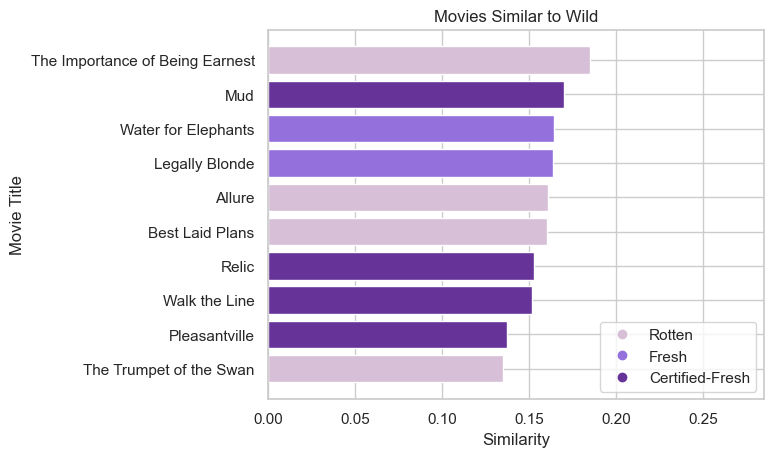

,Movie Title,Description,Release Date,Similarity,Count,Rating
8242,The Importance of Being Earnest,Two young gents have taken to bending the trut...,2002-05-31,0.184755,116.0,Rotten
10708,Mud,"While exploring a Mississippi River island, Ar...",2013-04-26,0.169839,181.0,Certified-Fresh
17068,Water for Elephants,"Jacob Jankowski (Robert Pattinson), a veterina...",2011-04-22,0.164073,197.0,Fresh
9364,Legally Blonde,Elle Woods (Reese Witherspoon) has it all. She...,2001-07-13,0.163802,147.0,Fresh
2563,Allure,Although Laura works as a house cleaner for he...,2018-03-16,0.160572,30.0,Rotten
3444,Best Laid Plans,Returning to his dreary hometown as a wealthy ...,1999-09-10,0.159964,21.0,Rotten
12405,Relic,A woman links her mother's increasingly volati...,2020-07-10,0.152562,193.0,Certified-Fresh
17001,Walk the Line,The rise of country music legend Johnny Cash (...,2005-11-18,0.151387,210.0,Certified-Fresh
11904,Pleasantville,Impressed by high school student David's (Tobe...,1998-10-23,0.137543,96.0,Certified-Fresh
16534,The Trumpet of the Swan,"In this animated feature, a swan named Louie (...",2001-05-11,0.134915,42.0,Rotten


In [169]:
# Test the recommender
content_recommender4("Wild")

The visual output of the recommender system has successfully been created, on which further testing will be carried out below.

Movie Name: It
Movie Description: 
When she first sets eyes on her new boss, the wealthy Cyrus Waltham Jr. (Antonio Moreno), department store clerk Betty Lou Spence (Clara Bow) is convinced he's got "it," an indefinable quality that makes one irresistible to the opposite sex. Betty Lou charms her employer on a date, but Cyrus suddenly cools when he hears a false story that Betty Lou has mothered an illegitimate child. Crushed by Cyrus' assumption, the shopgirl ramps up the sex appeal to win her man back and teach him a lesson.


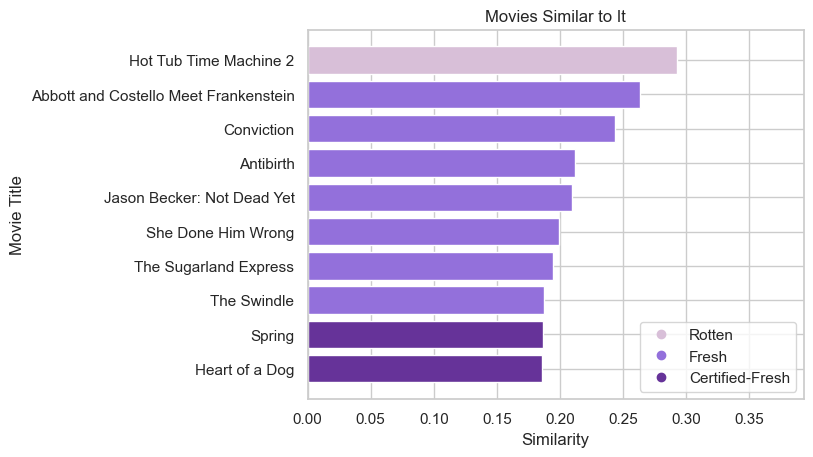

,Movie Title,Description,Release Date,Similarity,Count,Rating
7904,Hot Tub Time Machine 2,"After their first adventure with the ""Hot Tub ...",2015-02-20,0.293031,107.0,Rotten
2267,Abbott and Costello Meet Frankenstein,In the first of Bud Abbott and Lou Costello's ...,1948-06-15,0.263389,27.0,Fresh
4868,Conviction,When her older brother Kenny (Sam Rockwell) is...,2010-10-15,0.243901,190.0,Fresh
2832,Antibirth,"Hard-drinking, pill-popping, bong-ripping Lou ...",2016-09-02,0.212043,33.0,Fresh
8613,Jason Becker: Not Dead Yet,"Jason Becker, a 19-year-old rock star, hears t...",NaN,0.209702,24.0,Fresh
13186,She Done Him Wrong,Burlesque barroom singer Lady Lou (Mae West) k...,1933-02-09,0.199050,22.0,Fresh
15867,The Sugarland Express,Married small-time crooks Lou-Jean (Goldie Haw...,1974-01-01,0.194635,39.0,Fresh
15882,The Swindle,Con artists Victor (Michel Serrault) and Betty...,1997-10-24,0.186956,26.0,Fresh
13726,Spring,An aimless young man (Lou Taylor Pucci) takes ...,2015-03-20,0.186768,56.0,Certified-Fresh
7588,Heart of a Dog,Musician and performance artist Laurie Anderso...,2015-10-21,0.185797,90.0,Certified-Fresh


In [174]:
# Test the recommender
content_recommender4("It")

With the above test, the expected output was for the Stephen King movie 'It', however this was not the movie that was selected based on the highest rating filter that is currently used within the recommender system. This will be improved upon in the next iteration.

# 4.5 Iteration 5
The next iteration will include the `vote_threshold` within selection of the options for the movie index choice, and will also include a new `filt` input which will define whether any further multiple options will be selected by the highest average rating ('rating') or highest number of reviews ('reviews'). If something other than these two options are input, no recommendations will be made and an error message will be output to the user. The inputs are now defined as the following:

|Input|Definition|
|-|-|
|`title`|Movie Title - either exact or an excerpt|
|`filt`|How to select the movie from the list of options - 'rating' or 'reviews'|
|`movies`|Movie reference dataframe|
|`similarities`|Similarity matrix|
|`vote_threshold`|Minimum number of ratings for the movie to be considered|

In [269]:
def content_recommender5(title, filt = 'rating', movies = movies_df, similarities = similarities, vote_threshold=20) :
    
    # Get the movie by the contents of the title
    # first find if there are any exact matches
    movie_exact = movies[(movies['movie_title'] == title) & (movies['tomatometer_count'] > vote_threshold)].index
    # then also find if there are options that contain the text from the input
    movie_options = movies[(movies['movie_title'].str.contains(title)) & (movies['tomatometer_count'] > vote_threshold)].index

    if filt == 'rating':
        multi_filter = 'tomatometer_rating'
    elif filt == 'reviews':
        multi_filter = 'tomatometer_count'
    else:
        return print('Please define a valid filter of either \'rating\' or \'reviews\'.')
    
    # there can sometimes be movies with the same title, which needs to be assessed
    
    # need to check that the movie index is able to be found with the added vote_threshold added - if not, output error
    if (len(movie_exact) == 0) & (len(movie_options) == 0):
        return print('Movie not found - please check spelling or decrease the vote_threshold')
    # now check for an exact match, as this should be used over all others
    elif len(movie_exact) == 1:
        movie_index = movie_exact[0]
    # then check if there is only one option containing the input string
    elif len(movie_exact) > 1:
        exact_index = movies.iloc[movie_exact,:][[multi_filter]].values.argmax()
        movie_index = movie_exact[exact_index]    
    elif len(movie_options) == 1:
        movie_index = movie_options[0]        
    else:
        # if more than one movie, pick the one with the highest rating to compare against
        option_index = movies.iloc[movie_options,:][[multi_filter]].values.argmax()
        movie_index = movie_options[option_index]
    
    # define the full title of the move that is being compared
    movie_title = movies.iloc[movie_index,1]
    
    # Create a dataframe with the movie titles
    sim_df = pd.DataFrame(
        {'Movie Title': movies['movie_title'],
         'Description': movies['movie_info'],
         'Release Date': movies['original_release_date'],
         'Similarity': np.array(similarities[movie_index, :]).squeeze(),
         'Count': movies['tomatometer_count'],
         'Rating': movies['tomatometer_status']
        })
    
    # Get the top 10 movies above the threshold, not including the movie title that is being compared
    top_movies = sim_df[(sim_df['Count'] > vote_threshold) & (sim_df['Movie Title'] != movie_title)].sort_values(by='Similarity', ascending=False).head(10)
    
    #define the colours based on rating
    colour_map={"Rotten":"thistle","Fresh":"mediumpurple", "Certified-Fresh": "rebeccapurple"}
    colours = [colour_map[top_movies.loc[v,"Rating"]] for v in top_movies.index]
    
    print(f'Movie Name: \033[1m{movie_title}\033[0;0m')
    print(f'Movie Description: \n{sim_df.iloc[movie_index,1]}')
    
    #plot a graph
    plt.figure()
    sns.set_theme(style="whitegrid")
    plt.barh(top_movies['Movie Title'], top_movies['Similarity'], color = colours) # assign colours based on rating
       
    #plotting the legend
    markers = [plt.Line2D([0,0],[0,0],color=colour, marker='o', linestyle='') for colour in colour_map.values()]
    plt.legend(markers, colour_map.keys(), numpoints=1, loc = 'lower right')
    
    #labels
    plt.xlabel('Similarity')
    plt.ylabel('Movie Title')
    plt.title(f'Movies Similar to {movie_title}')
    plt.xlim((0,max(top_movies['Similarity'])+0.1))
    
    # have highest similarity movies at the top
    plt.gca().invert_yaxis()
    plt.show()


    
    return top_movies

Movie Name: It
Movie Description: 
Seven young outcasts in Derry, Maine, are about to face their worst nightmare -- an ancient, shape-shifting evil that emerges from the sewer every 27 years to prey on the town's children. Banding together over the course of one horrifying summer, the friends must overcome their own personal fears to battle the murderous, bloodthirsty clown known as Pennywise.


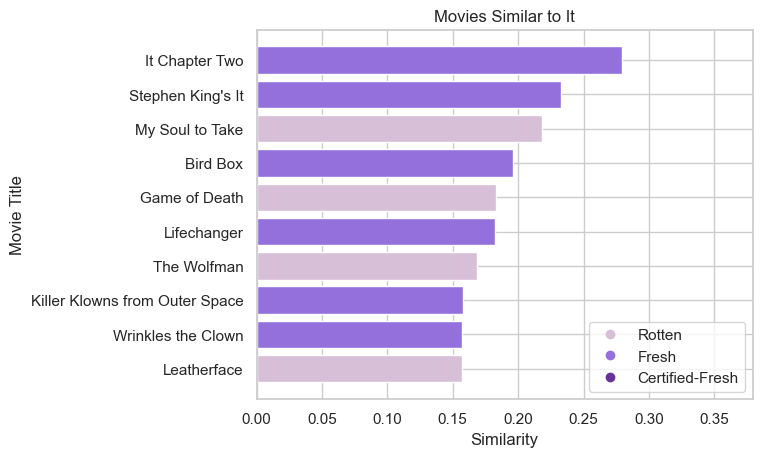

,Movie Title,Description,Release Date,Similarity,Count,Rating
8505,It Chapter Two,"Defeated by members of the Losers' Club, the e...",2019-09-06,0.279194,367.0,Fresh
13870,Stephen King's It,"In 1960, seven preteen outcasts fight an evil ...",1990-11-18,0.232539,24.0,Fresh
1936,My Soul to Take,"In the small town of Riverton, a local legend ...",2010-10-08,0.218159,63.0,Rotten
3604,Bird Box,When a mysterious force decimates the populati...,2018-12-13,0.195778,160.0,Fresh
6861,Game of Death,"Under the spell of an evil board game, seven t...",2020-07-14,0.183402,27.0,Rotten
9506,Lifechanger,A murderous shape shifter sheds blood to make ...,2018-12-05,0.182173,22.0,Fresh
1666,The Wolfman,Though absent from his ancestral home of Black...,2010-02-12,0.168855,219.0,Rotten
8977,Killer Klowns from Outer Space,When teenagers Mike (Grant Cramer) and Debbie ...,1988-01-01,0.157800,24.0,Fresh
17543,Wrinkles the Clown,Mysterious videos appear on the internet of a ...,2019-10-04,0.157265,34.0,Fresh
9344,Leatherface,A violent teen and three others kidnap a young...,2017-10-20,0.156958,44.0,Rotten


In [242]:
# Test the recommender
content_recommender5("It")

The above output shows that the addition of the review count filtering within the movie index selection has improved the recommender results. Further testing of the recommender system is carried out below.

In [200]:
# Test the recommender
content_recommender5("Wild", filt = 'length')

Please define a valid filter of 'rating' or 'reviews'


Movie Name: Pride and Prejudice and Zombies
Movie Description: 
In the 19th century, a mysterious plague turns the English countryside into a war zone. No one is safe as the dead come back to life to terrorize the land. Fate leads Elizabeth Bennet (Lily James), a master of martial arts and weaponry, to join forces with Mr. Darcy (Sam Riley), a handsome but arrogant gentleman. Elizabeth can't stand Darcy, but respects his skills as a zombie killer. Casting aside their personal differences, they unite on the blood-soaked battlefield to save their country.


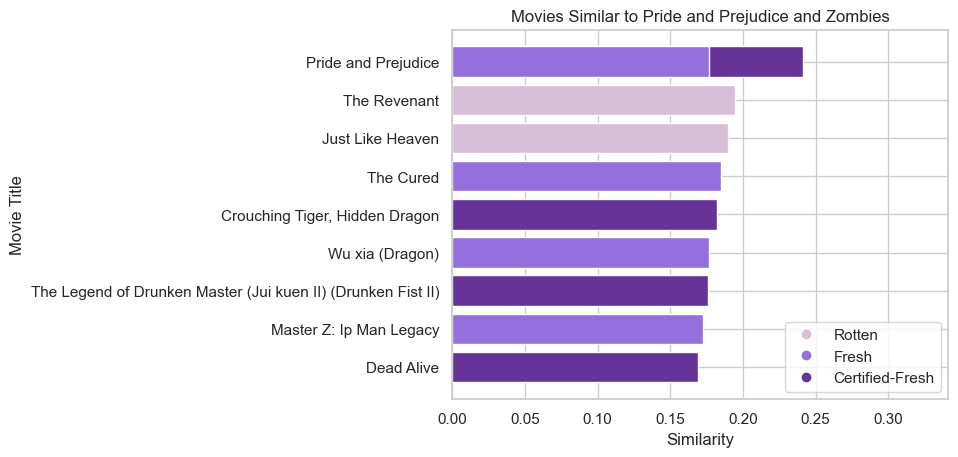

,Movie Title,Description,Release Date,Similarity,Count,Rating
1503,Pride and Prejudice,In this adaptation of Jane Austen's beloved no...,2005-11-11,0.241435,180.0,Certified-Fresh
15718,The Revenant,A dead soldier (David Anders) comes back to li...,2012-08-24,0.194378,26.0,Rotten
8844,Just Like Heaven,David (Mark Ruffalo) is a recently widowed arc...,2005-09-16,0.189842,151.0,Rotten
14775,The Cured,After years of a zombie plague that ravaged Eu...,2018-02-23,0.185007,65.0,Fresh
5013,"Crouching Tiger, Hidden Dragon","In 19th century Qing Dynasty China, a warrior ...",2001-01-12,0.182029,157.0,Certified-Fresh
1454,Pride and Prejudice,In this modern take on the Jane Austen classic...,2003-12-05,0.176665,29.0,Fresh
17552,Wu xia (Dragon),A martial arts master with a dark past wants t...,2012-11-30,0.176498,27.0,Fresh
9370,The Legend of Drunken Master (Jui kuen II) (Dr...,"From a land where honor and tradition reign, c...",NaN,0.175774,78.0,Certified-Fresh
10171,Master Z: Ip Man Legacy,"Defeated by Master Ip, martial arts expert Che...",2019-04-12,0.172263,37.0,Fresh
5247,Dead Alive,Overprotective mother Vera Cosgrove (Elizabeth...,1993-02-12,0.169397,42.0,Certified-Fresh


In [196]:
# Test the recommender
content_recommender5("Pride and Prejudice and Zombies")

The test case above has raised an error with the graph plotting when the recommended movies produced more than one movie of the exact same name. This will be resolved in the next iteration.

# 4.6 Iteration 6
This final iteration of the recommender system has fixed the error coming from multiple movies of the same name within the recommendations, and has also added an extra input to the function defining whether the user would like to include movies defined as 'Rotten' within the list of recommendations. The final list of inputs are defined as the following:

|Input|Definition|Default Value
|-|-|-|
|`title`|Movie Title - either exact or an excerpt|-|
|`filt`|How to select the movie from the list of options - 'rating' or 'reviews'|'rating'|
|`movies`|Movie reference dataframe|`movies_df`|
|`similarities`|Similarity matrix|`similarities` (3000 components)|
|`vote_threshold`|Minimum number of ratings for the movie to be considered|20|
|`rotten`|Option to include 'Rotten' reviews in recommendation table - True or False|True|

In [268]:
def content_recommender6(title, filt = 'rating', movies = movies_df, similarities = similarities, vote_threshold=20, rotten = True) :
    
    # Get the movie by the contents of the title
    # first find if there are any exact matches
    movie_exact = movies[(movies['movie_title'] == title) & (movies['tomatometer_count'] > vote_threshold)].index
    # then also find if there are options that contain the text from the input
    movie_options = movies[(movies['movie_title'].str.contains(title)) & (movies['tomatometer_count'] > vote_threshold)].index

    if filt == 'rating':
        multi_filter = 'tomatometer_rating'
    elif filt == 'reviews':
        multi_filter = 'tomatometer_count'
    else:
        return print('Please define a valid filter of either \'rating\' or \'reviews\'.')
    
    # there can sometimes be movies with the same title, which needs to be assessed
    
        # need to check that the movie index is able to be found with the added vote_threshold added - if not, output error
    if (len(movie_exact) == 0) & (len(movie_options) == 0):
        return print('Movie not found - please check spelling or decrease the vote_threshold')
    # now check for an exact match, as this should be used over all others
    if len(movie_exact) == 1:
        movie_index = movie_exact[0]
    # then check if there is only one option containing the input string
    elif len(movie_exact) > 1:
        exact_index = movies.iloc[movie_exact,:][[multi_filter]].values.argmax()
        movie_index = movie_exact[exact_index]    
    elif len(movie_options) == 1:
        movie_index = movie_options[0]        
    else:
        # if more than one movie, pick the one with the highest rating to compare against
        option_index = movies.iloc[movie_options,:][[multi_filter]].values.argmax()
        movie_index = movie_options[option_index]
    
    # define the full title of the move that is being compared
    movie_title = movies.iloc[movie_index,1]
    
    # Create a dataframe with the movie titles
    sim_df = pd.DataFrame(
        {'Movie Title': movies['movie_title'],
         'Description': movies['movie_info'],
         'Release Date': movies['original_release_date'],
         'Similarity': np.array(similarities[movie_index, :]).squeeze(),
         'Count': movies['tomatometer_count'],
         'Rating': movies['tomatometer_status']
        })
    
    # include filter option to not include movies rated rotten within the output
    if rotten == True:
         # Get the top 10 movies above the threshold, not including the movie title that is being compared
        top_movies = sim_df[(sim_df['Count'] > vote_threshold) & (sim_df['Movie Title'] != movie_title)].sort_values(by='Similarity', ascending=False).head(10)
    else:
        top_movies = sim_df[(sim_df['Count'] > vote_threshold) & (sim_df['Movie Title'] != movie_title) & (sim_df['Rating'] != 'Rotten')].sort_values(by='Similarity', ascending=False).head(10)
    
    #define the colours based on rating
    colour_map={"Rotten":"thistle","Fresh":"mediumpurple", "Certified-Fresh": "rebeccapurple"}
    colours = [colour_map[top_movies.loc[v,"Rating"]] for v in top_movies.index]
    
    # printing selected movie name, rating and description
    print(f'Movie Name: \033[1m{movie_title}\033[0;0m')
    print(f'Movie Rating: \033[1m{sim_df.iloc[movie_index,5]}\033[0;0m')
    print(f'Movie Description: \n{sim_df.iloc[movie_index,1]}')
    
    #plot a graph
    
    # define ylabels to prevent duplicating
    ylabel = list(top_movies['Movie Title'])
    
    plt.figure()
    sns.set_theme(style="whitegrid")
    # plot barplot with numeric y coordinates 1-10
    plt.barh(range(1,11), top_movies['Similarity'], color = colours) # assign colours based on rating
    # re-define ylabels based on ylabel list
    plt.yticks(range(1,11), ylabel)
       
    #plotting the legend
    markers = [plt.Line2D([0,0],[0,0],color=colour, marker='o', linestyle='') for colour in colour_map.values()]
    plt.legend(markers, colour_map.keys(), numpoints=1, loc = 'lower right')
    
    #labels
    plt.xlabel('Similarity')
    plt.ylabel('Movie Title')
    plt.title(f'Movies Similar to {movie_title}')
    plt.xlim((0,max(top_movies['Similarity'])+0.1))
    
    # have highest similarity movies at the top
    plt.gca().invert_yaxis()
    plt.show()
   
    return top_movies

Movie Name: Pride and Prejudice and Zombies
Movie Rating: Rotten
Movie Description: 
In the 19th century, a mysterious plague turns the English countryside into a war zone. No one is safe as the dead come back to life to terrorize the land. Fate leads Elizabeth Bennet (Lily James), a master of martial arts and weaponry, to join forces with Mr. Darcy (Sam Riley), a handsome but arrogant gentleman. Elizabeth can't stand Darcy, but respects his skills as a zombie killer. Casting aside their personal differences, they unite on the blood-soaked battlefield to save their country.


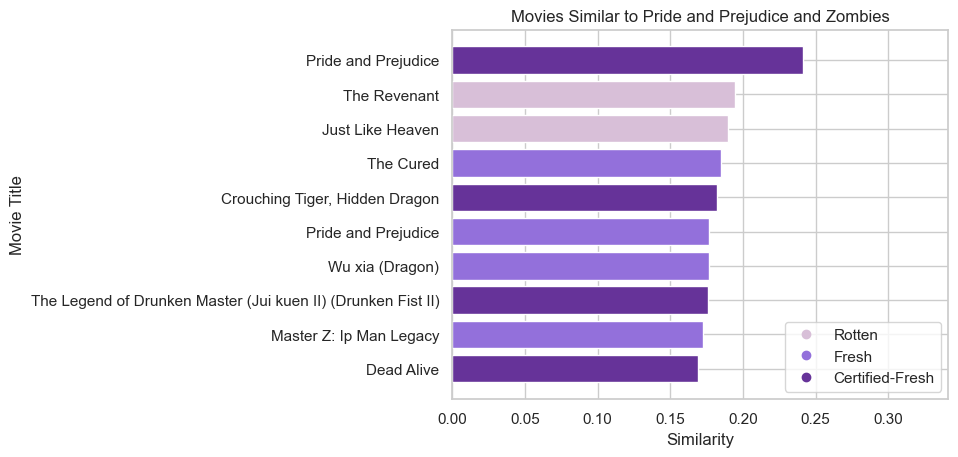

,Movie Title,Description,Release Date,Similarity,Count,Rating
1503,Pride and Prejudice,In this adaptation of Jane Austen's beloved no...,2005-11-11,0.241435,180.0,Certified-Fresh
15718,The Revenant,A dead soldier (David Anders) comes back to li...,2012-08-24,0.194378,26.0,Rotten
8844,Just Like Heaven,David (Mark Ruffalo) is a recently widowed arc...,2005-09-16,0.189842,151.0,Rotten
14775,The Cured,After years of a zombie plague that ravaged Eu...,2018-02-23,0.185007,65.0,Fresh
5013,"Crouching Tiger, Hidden Dragon","In 19th century Qing Dynasty China, a warrior ...",2001-01-12,0.182029,157.0,Certified-Fresh
1454,Pride and Prejudice,In this modern take on the Jane Austen classic...,2003-12-05,0.176665,29.0,Fresh
17552,Wu xia (Dragon),A martial arts master with a dark past wants t...,2012-11-30,0.176498,27.0,Fresh
9370,The Legend of Drunken Master (Jui kuen II) (Dr...,"From a land where honor and tradition reign, c...",NaN,0.175774,78.0,Certified-Fresh
10171,Master Z: Ip Man Legacy,"Defeated by Master Ip, martial arts expert Che...",2019-04-12,0.172263,37.0,Fresh
5247,Dead Alive,Overprotective mother Vera Cosgrove (Elizabeth...,1993-02-12,0.169397,42.0,Certified-Fresh


In [306]:
# Test the recommender
content_recommender6("Pride and Prejudice and Zombies")

The above test proves the fix to the graphical output, and also makes use of the new filter to not include 'Rotten' movies within the output. Further testing is carried out, with no obvious errors shown.

Movie Name: Shrek
Movie Rating: Certified-Fresh
Movie Description: 
Once upon a time, in a far away swamp, there lived an ogre named Shrek (Mike Myers) whose precious solitude is suddenly shattered by an invasion of annoying fairy tale characters. They were all banished from their kingdom by the evil Lord Farquaad (John Lithgow). Determined to save their home -- not to mention his -- Shrek cuts a deal with Farquaad and sets out to rescue Princess Fiona (Cameron Diaz) to be Farquaad's bride. Rescuing the Princess may be small compared to her deep, dark secret.


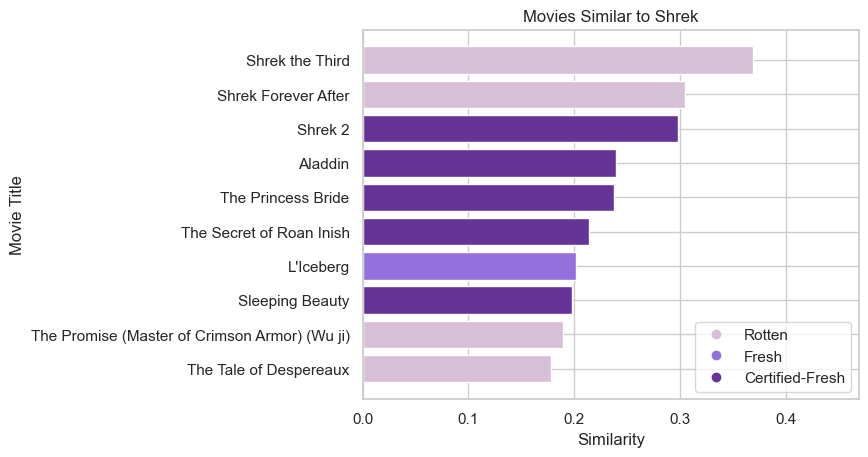

,Movie Title,Description,Release Date,Similarity,Count,Rating
13277,Shrek the Third,"When King Harold suddenly croaks, Shrek (Mike ...",2007-05-18,0.369161,213.0,Rotten
13278,Shrek Forever After,Long-settled into married life and fully domes...,2010-05-21,0.304694,199.0,Rotten
13276,Shrek 2,After returning from their honeymoon and showi...,2004-05-19,0.298485,236.0,Certified-Fresh
5555,Aladdin,When street rat Aladdin frees a genie from a l...,1992-11-11,0.239754,75.0,Certified-Fresh
12060,The Princess Bride,A fairy tale adventure about a beautiful young...,1987-09-25,0.237539,77.0,Certified-Fresh
14444,The Secret of Roan Inish,Fiona (Jeni Courtney) is a young Irish girl wi...,1995-02-03,0.214110,44.0,Certified-Fresh
9135,L'Iceberg,"Fiona (Fiona Gordon), the manager of a fast-fo...",2005-09-17,0.201327,32.0,Fresh
734,Sleeping Beauty,"Filled with jealousy, the evil witch Maleficen...",1959-01-29,0.198273,44.0,Certified-Fresh
1511,The Promise (Master of Crimson Armor) (Wu ji),In ancient China a fleet-footed slave named Ku...,2005-12-15,0.189697,78.0,Rotten
14222,The Tale of Despereaux,Once a thriving place of sunshine and deliciou...,2008-12-19,0.178485,110.0,Rotten


In [230]:
# Test the recommender
content_recommender6("Shrek")

This will now be taken as the optimised recommender system function, with the next step to now look into altering the default inputs to provide a better prediction.

## 4.7 Altering Inputs

As detailed earlier, there are multiple inputs to recommender system function that can be changed by the user, and a couple of these can have a large input on the results and should be fixed.

One of these is the movies database, which should be fixed to be `movies_df` in order that no errors are thrown out by the function. 

The second input to be fixed is the similarity matrix, which currently has four possible inputs as defined previously. A number of tests have been carried out on these, and the following conclusions have been made:

|Name|Description|Findings|
|-|-|-|
|`similarities`|5000 components reduced to 3000 components|Particularly good at finding movies within a series|
|`similarities2`|All keywords with 5000 components|Similar to the results from the above|
|`similarities3`|All keywords, `min_df` set to 30 (4113 components)|Finds more specific relationships in content|
|`similarities4`|Keywords with only top 4 actors with 5000 components|Focus's very heavily on the actors|

Based on this, `similarities3` will be assigned as the default similarity matrix to use within the recommender system, with this not able to be updated by the user.

Finally, the `vote_threshold` default value will be increased to 50, as this results in more well known movies to be recommended.

The possible inputs by the user will therefore be set as the following for the optimal system:

|Input|Definition|Default Value
|-|-|-|
|`title`|Movie Title - either exact or an excerpt|-|
|`filt`|How to select the movie from the list of options - 'rating' or 'reviews'|'rating'|
|`vote_threshold`|Minimum number of ratings for the movie to be considered|50|
|`rotten`|Option to include 'Rotten' reviews in recommendation table - True or False|True|

Movie Name: Clueless
Movie Rating: Certified-Fresh
Movie Description: 
Shallow, rich and socially successful Cher (Alicia Silverstone) is at the top of her Beverly Hills high school's pecking scale. Seeing herself as a matchmaker, Cher first coaxes two teachers into dating each other. Emboldened by her success, she decides to give hopelessly klutzy new student Tai (Brittany Murphy) a makeover. When Tai becomes more popular than she is, Cher realizes that her disapproving ex-stepbrother (Paul Rudd) was right about how misguided she was -- and falls for him.


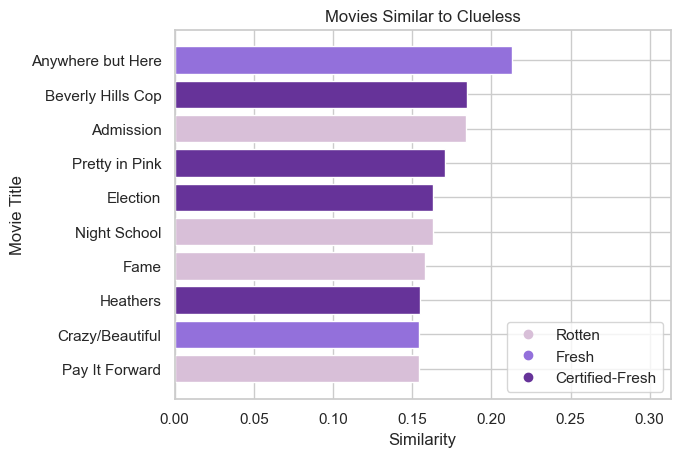

,Movie Title,Description,Release Date,Similarity,Count,Rating
2854,Anywhere but Here,"In this adaptation of the Mona Simpson novel, ...",2000-06-01,0.213213,89.0,Fresh
3477,Beverly Hills Cop,After his childhood buddy is murdered while vi...,1984-12-01,0.184837,51.0,Certified-Fresh
2344,Admission,When straight-laced Princeton University admis...,2013-03-22,0.183732,157.0,Rotten
12025,Pretty in Pink,Andie (Molly Ringwald) is an outcast at her Ch...,1986-02-28,0.170438,52.0,Certified-Fresh
5936,Election,"Jim McAllister (Matthew Broderick), a well-lik...",1999-05-03,0.163340,113.0,Certified-Fresh
11065,Night School,Teddy Walker is a successful salesman whose li...,2018-09-28,0.163168,140.0,Rotten
237,Fame,"At New York's High School of Performing Arts, ...",2009-09-25,0.158002,122.0,Rotten
7605,Heathers,Veronica (Winona Ryder) is part of the most po...,1988-06-01,0.155164,57.0,Certified-Fresh
4947,Crazy/Beautiful,Two high school students from opposite ends of...,2001-06-28,0.154628,99.0,Fresh
11693,Pay It Forward,The story of a social studies teacher who give...,2000-10-20,0.154282,130.0,Rotten


In [372]:
content_recommender6("Clueless", similarities = similarities3, vote_threshold = 50)

# 5 Optimal Recommender System
The final recommender system is defined below.

In [87]:
def content_recommender(title, filt = 'rating', vote_threshold=50, rotten = True) :
    
    """
    This function is used to run the content based recommender system.
    The purpose of this system is for the user to input the name of a movie, and the function will output the top 10 movies
    which have the highest similarity to the input, based on the keywords related to the given movie.
    
    Parameters:
    -----------
    
    title:  Movie Title
            Can be exact or just a small fraction of the movie title, which will be selected based on the filter provided
    filt:   Selection filter
            Either 'rating' or 'reviews'
            Defines the method used to select the film title if there are multiple results for the given input
            'ratings' = outputs the movie with the highest average rating
            'reviews' = outputs the movie with the highest number of reviews
    vote_threshold: Minimum number of reviews required for the movie to be counted
            Default = 50
            Only movies which have been reviewed more times that this input will be included in the recommendations
    rotten: Boolean input on whether Rotten movies should be included in the recommendations
            Default = True (Rotten movies will be included)
            
    Returns:
    -------
    
    top_movies: Top 10 movies most similar to selected input movie, based on keywords
    
    Other Outputs:
    --------
    
    Movie Title: Full title of movie defined as the input to the function
    
    Movie Description: Full description of the input movie
    
    Graph:  Graphical output of the similarity score for each of the predicted recommendations.
            Each output is coloured based on the overall classification score of the movie.
    
    """
        
    
    # Get the movie by the contents of the title
    # first find if there are any exact matches
    movie_exact = movies_df[(movies_df['movie_title'] == title) & (movies_df['tomatometer_count'] > vote_threshold)].index
    # then also find if there are options that contain the text from the input
    movie_options = movies_df[(movies_df['movie_title'].str.contains(title)) & (movies_df['tomatometer_count'] > vote_threshold)].index

    if filt == 'rating':
        multi_filter = 'tomatometer_rating'
    elif filt == 'reviews':
        multi_filter = 'tomatometer_count'
    else:
        return print('Please define a valid filter of either \'rating\' or \'reviews\'.')
    
    # there can sometimes be movies with the same title, which needs to be assessed
    
    # need to check that the movie index is able to be found with the added vote_threshold added - if not, output error
    if (len(movie_exact) == 0) & (len(movie_options) == 0):
        return print('Movie not found - please check spelling or decrease the vote_threshold')
    # now check for an exact match, as this should be used over all others
    elif len(movie_exact) == 1:
        movie_index = movie_exact[0]
    # then check if there is only one option containing the input string
    elif len(movie_exact) > 1:
        exact_index = movies_df.iloc[movie_exact,:][[multi_filter]].values.argmax()
        movie_index = movie_exact[exact_index]    
    elif len(movie_options) == 1:
        movie_index = movie_options[0]        
    else:
        # if more than one movie, pick the one with the highest rating to compare against
        option_index = movies_df.iloc[movie_options,:][[multi_filter]].values.argmax()
        movie_index = movie_options[option_index]
    
    # define the full title of the move that is being compared
    movie_title = movies_df.iloc[movie_index,1]
    
    # Create a dataframe with the movie titles
    sim_df = pd.DataFrame(
        {'Movie Title': movies_df['movie_title'],
         'Description': movies_df['movie_info'],
         'Release Date': movies_df['original_release_date'],
         'Similarity': np.array(similarities3[movie_index, :]).squeeze(),
         'Count': movies_df['tomatometer_count'],
         'Rating': movies_df['tomatometer_status']
        })
    
    # include filter option to not include movies rated rotten within the output
    if rotten == True:
         # Get the top 10 movies above the threshold, not including the movie title that is being compared
        top_movies = sim_df[(sim_df['Count'] > vote_threshold) & (sim_df['Movie Title'] != movie_title)].sort_values(by='Similarity', ascending=False).head(10)
    else:
        top_movies = sim_df[(sim_df['Count'] > vote_threshold) & (sim_df['Movie Title'] != movie_title) & (sim_df['Rating'] != 'Rotten')].sort_values(by='Similarity', ascending=False).head(10)
    
    #define the colours based on rating
    colour_map={"Rotten":"thistle","Fresh":"mediumpurple", "Certified-Fresh": "rebeccapurple"}
    colours = [colour_map[top_movies.loc[v,"Rating"]] for v in top_movies.index]
    
    # printing selected movie name, rating and description
    print(f'Movie Name: \033[1m{movie_title}\033[0;0m')
    print(f'Movie Rating: \033[1m{sim_df.iloc[movie_index,5]}\033[0;0m')
    print(f'Movie Description: \n{sim_df.iloc[movie_index,1]}')
    
    #plot a graph
    
    # define ylabels to prevent duplicating
    ylabel = list(top_movies['Movie Title'])
    
    plt.figure()
    sns.set_theme(style="whitegrid")
    # plot barplot with numeric y coordinates 1-10
    plt.barh(range(1,11), top_movies['Similarity'], color = colours) # assign colours based on rating
    # re-define ylabels based on ylabel list
    plt.yticks(range(1,11), ylabel)
       
    #plotting the legend
    markers = [plt.Line2D([0,0],[0,0],color=colour, marker='o', linestyle='') for colour in colour_map.values()]
    plt.legend(markers, colour_map.keys(), numpoints=1, loc = 'lower right')
    
    #labels
    plt.xlabel('Similarity')
    plt.ylabel('Movie Title')
    plt.title(f'Movies Similar to {movie_title} based on Movie Content')
    plt.xlim((0,max(top_movies['Similarity'])+0.1))
    
    # have highest similarity movies at the top
    plt.gca().invert_yaxis()
    plt.show()
   
    return top_movies

Movie Name: Thor
Movie Rating: Certified-Fresh
Movie Description: 
As the son of Odin (Anthony Hopkins), king of the Norse gods, Thor (Chris Hemsworth) will soon inherit the throne of Asgard from his aging father. However, on the day that he is to be crowned, Thor reacts with brutality when the gods' enemies, the Frost Giants, enter the palace in violation of their treaty. As punishment, Odin banishes Thor to Earth. While Loki (Tom Hiddleston), Thor's brother, plots mischief in Asgard, Thor, now stripped of his powers, faces his greatest threat.


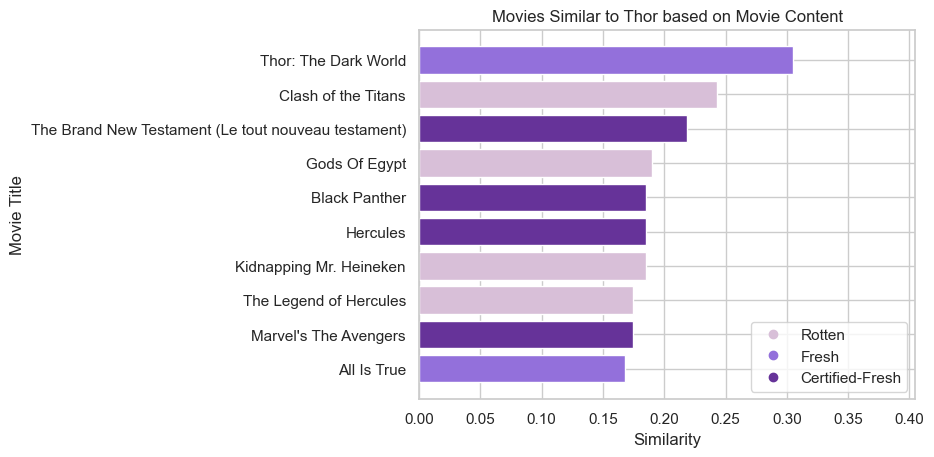

,Movie Title,Description,Release Date,Similarity,Count,Rating
16197,Thor: The Dark World,"In ancient times, the gods of Asgard fought an...",2013-11-08,0.304608,279.0,Fresh
4661,Clash of the Titans,"Perseus (Sam Worthington), the son of Zeus (Li...",2010-04-02,0.243316,264.0,Rotten
14651,The Brand New Testament (Le tout nouveau testa...,God is discovered living in Brussels with his ...,2016-12-09,0.218885,77.0,Certified-Fresh
7101,Gods Of Egypt,The survival of mankind hangs in the balance w...,2016-02-26,0.189640,192.0,Rotten
3662,Black Panther,"After the death of his father, T'Challa return...",2018-02-16,0.185387,512.0,Certified-Fresh
7689,Hercules,Disney tackles Greek mythology in this animate...,1997-06-15,0.185066,55.0,Certified-Fresh
8950,Kidnapping Mr. Heineken,"In 1983, five longtime friends successfully ki...",2015-03-06,0.184705,62.0,Rotten
15361,The Legend of Hercules,"As the son of Zeus, king of the gods, and a mo...",2014-01-10,0.174252,82.0,Rotten
10149,Marvel's The Avengers,"When Thor's evil brother, Loki (Tom Hiddleston...",2012-05-04,0.174203,357.0,Certified-Fresh
2529,All Is True,"The year is 1613, and Shakespeare is acknowled...",2019-05-10,0.167607,138.0,Fresh


In [89]:
content_recommender("Thor")

Movie Name: Frozen
Movie Rating: Certified-Fresh
Movie Description: 
When their kingdom becomes trapped in perpetual winter, fearless Anna (Kristen Bell) joins forces with mountaineer Kristoff (Jonathan Groff) and his reindeer sidekick to find Anna's sister, Snow Queen Elsa (Idina Menzel), and break her icy spell. Although their epic journey leads them to encounters with mystical trolls, a comedic snowman (Josh Gad), harsh conditions, and magic at every turn, Anna and Kristoff bravely push onward in a race to save their kingdom from winter's cold grip.


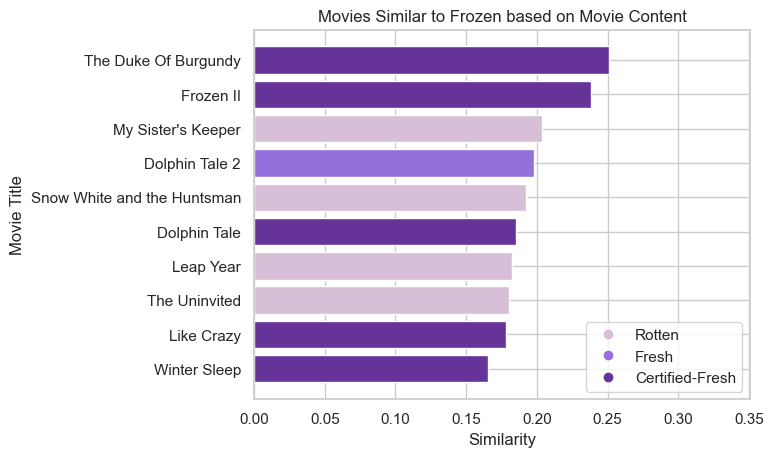

,Movie Title,Description,Release Date,Similarity,Count,Rating
14876,The Duke Of Burgundy,"Two entomologists (Sidse Babett Knudsen, Chiar...",2015-01-23,0.250881,103.0,Certified-Fresh
6808,Frozen II,Elsa the Snow Queen has an extraordinary gift ...,2019-11-21,0.238069,325.0,Certified-Fresh
212,My Sister's Keeper,Conceived as a marrow donor for her gravely il...,2009-06-26,0.203356,137.0,Rotten
5614,Dolphin Tale 2,Several years have passed since Sawyer Nelson ...,2014-09-12,0.198343,87.0,Fresh
13489,Snow White and the Huntsman,"Queen Ravenna (Charlize Theron), who seized co...",2012-06-01,0.192520,237.0,Rotten
5613,Dolphin Tale,"While swimming free in the ocean, a young dolp...",2011-09-23,0.185172,113.0,Certified-Fresh
9340,Leap Year,When yet another anniversary passes without a ...,2010-01-08,0.182666,139.0,Rotten
16730,The Uninvited,"After spending time in a psychiatric facility,...",2009-01-30,0.180228,129.0,Rotten
9519,Like Crazy,"While attending college in Los Angeles, Jacob ...",2011-10-28,0.178440,155.0,Certified-Fresh
9040,Winter Sleep,"Aydin, his wife and his recently divorced sist...",2014-12-19,0.165588,83.0,Certified-Fresh


In [88]:
content_recommender("Frozen")

# 6 Next Steps
The content based recommender system is now complete (and generally accurate), with the aim for it to be incorporated within a *Streamlit App* in order to be able to present recommendations to the end user.

Possible improvements can be looked into in terms of splitting out the `keywords` column and vectorising/one-hot encoding each column seperately, as this will likely result in higher weighting being applied to different attributes (i.e. directors or ratings).

---